# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [2]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

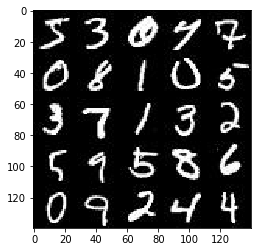

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

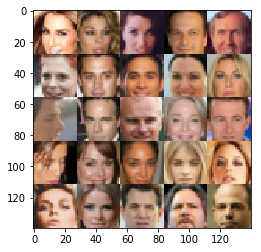

In [4]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [5]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.3.0


/Users/Sljux/miniconda3/envs/tensorflow/lib/python3.5/site-packages/ipykernel_launcher.py:14: UserWarning: No GPU found. Please use a GPU to train your neural network.
  


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [6]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    real_inputs = tf.placeholder(tf.float32, [None, image_width, image_height, image_channels])
    z_inputs = tf.placeholder(tf.float32, [None, z_dim])
    learn_rate = tf.placeholder(tf.float32, None)

    return real_inputs, z_inputs, learn_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.framework.ops.Operation'>):
<tf.Operation 'assert_rank_2/Assert/Assert' type=Assert>
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
['File "/Users/Sljux/miniconda3/envs/tensorflow/lib/python3.5/runpy.py", line 193, in _run_module_as_main\n    "__main__", mod_spec)', 'File "/Users/Sljux/miniconda3/envs/tensorflow/lib/python3.5/runpy.py", line 85, in _run_code\n    exec(code, run_globals)', 'File "/Users/Sljux/miniconda3/envs/tensorflow/lib/python3.5/site-packages/ipykernel_launcher.py", line 16, in <module>\n    app.launch_new_instance()', 'File "/Users/Sljux/miniconda3/envs/tensorflow/lib/python3.5/site-packages/traitlets/config/application.py", line 658, in launch_instance\n    app.start()', 'File "/Users/Sljux/miniconda3/envs/tensorflow/lib/python3.5/site-packages/ipykernel/kernelapp.py", line 477, in start\n    ioloop.IOLoop.instanc

### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [9]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    alpha = 0.2
    keep_prob = 0.8
    
    initializer = tf.contrib.layers.xavier_initializer_conv2d()
        
    with tf.variable_scope('discriminator', reuse=reuse):
        conv = tf.layers.conv2d(images, 64, 5, 2, 'same', kernel_initializer=initializer)
        conv = tf.maximum(alpha * conv, conv)
        conv = tf.nn.dropout(conv, keep_prob)
        
        conv = tf.layers.conv2d(conv, 128, 5, 2, 'same', kernel_initializer=initializer)
        conv = tf.layers.batch_normalization(conv, training=True)
        conv = tf.maximum(alpha * conv, conv)
        conv = tf.nn.dropout(conv, keep_prob)
        
        conv = tf.layers.conv2d(conv, 256, 5, 2, 'same', kernel_initializer=initializer)
        conv = tf.layers.batch_normalization(conv, training=True)
        conv = tf.maximum(alpha * conv, conv)
        conv = tf.nn.dropout(conv, keep_prob)
        
        logits = tf.layers.dense(tf.contrib.layers.flatten(conv), 1)
        output = tf.sigmoid(logits)
        
        return output, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [24]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    alpha = 0.2
    keep_prob = 0.5
    
    with tf.variable_scope('generator', reuse=not is_train):
        conv = tf.layers.dense(z, 7 * 7 * 512)
        conv = tf.reshape(conv, [-1, 7, 7, 512])
        conv = tf.layers.batch_normalization(conv, training=is_train)
        conv = tf.maximum(alpha * conv, conv)
        conv = tf.nn.dropout(conv, keep_prob)
    
        conv = tf.layers.conv2d_transpose(conv, 256, 5, 2, 'same')
        conv = tf.layers.batch_normalization(conv, training=is_train)
        conv = tf.maximum(alpha * conv, conv)
        conv = tf.nn.dropout(conv, keep_prob)
    
        conv = tf.layers.conv2d_transpose(conv, 128, 5, 2, 'same')
        conv = tf.layers.batch_normalization(conv, training=is_train)
        conv = tf.maximum(alpha * conv, conv)
        conv = tf.nn.dropout(conv, keep_prob)
    
        conv = tf.layers.conv2d_transpose(conv, 64, 5, 1, 'same')
        conv = tf.layers.batch_normalization(conv, training=is_train)
        conv = tf.maximum(alpha * conv, conv)
        conv = tf.nn.dropout(conv, keep_prob)
    
        conv = tf.layers.conv2d_transpose(conv, 32, 5, 1, 'same')
        conv = tf.layers.batch_normalization(conv, training=is_train)
        conv = tf.maximum(alpha * conv, conv)
        conv = tf.nn.dropout(conv, keep_prob)
    
        logits = tf.layers.conv2d_transpose(conv, out_channel_dim, 5, 1, 'same')
        output = tf.tanh(logits)
    
        return output


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [25]:
tf.reset_default_graph()


def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    
    smooth = 0.1
    
    g_out = generator(input_z, out_channel_dim)
    d_model_real, d_logits_real = discriminator(input_real)
    d_model_fake, d_logits_fake = discriminator(g_out, reuse=True)
    
    d_real_labels = tf.ones_like(d_model_real) * (1 - smooth)
    d_loss_real = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=d_real_labels))
    
    d_fake_labels = tf.zeros_like(d_model_fake)
    d_loss_fake = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=d_fake_labels))
    
    d_loss = d_loss_real + d_loss_fake
    
    g_labels = tf.ones_like(d_model_fake)
    g_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=g_labels))
    
    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [26]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]
    
    d_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
    
    ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
    g_updates = [opt for opt in ops if opt.name.startswith('generator')]
    
    with tf.control_dependencies(g_updates):
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)
        
    return d_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [27]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [28]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    _, img_width, img_height, img_channels = data_shape
    
    real_input, z_input, learn_rate = model_inputs(img_width, img_height, img_channels, z_dim)
    
    d_loss, g_loss = model_loss(real_input, z_input, img_channels)
    d_opt, g_opt = model_opt(d_loss, g_loss, learning_rate, beta1)
    
    batches = 0
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                # TODO: Train Model
                batches += 1
                
                batch_images *= 2.0
                
                z_batches = np.random.uniform(-1, 1, (batch_size, z_dim))
                
                sess.run(d_opt, feed_dict={real_input: batch_images, z_input: z_batches, learn_rate: learning_rate})
                sess.run(d_opt, feed_dict={real_input: batch_images, z_input: z_batches, learn_rate: learning_rate})
                sess.run(g_opt, feed_dict={z_input: z_batches, learn_rate: learning_rate})
                
                if batches % 100 == 0:
                    show_generator_output(sess, 9, z_input, img_channels, data_image_mode)
                    
                if batches % 10 == 0:
                    train_loss_d = d_loss.eval({z_input: z_batches, real_input: batch_images})
                    train_loss_g = g_loss.eval({z_input: z_batches})
                    
                    print("Epoch {}/{}...".format(epoch_i + 1, epoch_count),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Discriminator Loss: 1.4176... Generator Loss: 1.9539
Epoch 1/2... Discriminator Loss: 0.4876... Generator Loss: 3.3673
Epoch 1/2... Discriminator Loss: 0.8334... Generator Loss: 1.9634
Epoch 1/2... Discriminator Loss: 1.6115... Generator Loss: 0.8183
Epoch 1/2... Discriminator Loss: 0.7372... Generator Loss: 2.5088
Epoch 1/2... Discriminator Loss: 0.9550... Generator Loss: 1.2339
Epoch 1/2... Discriminator Loss: 1.2508... Generator Loss: 0.7282
Epoch 1/2... Discriminator Loss: 1.5513... Generator Loss: 0.5797
Epoch 1/2... Discriminator Loss: 1.7474... Generator Loss: 0.7073


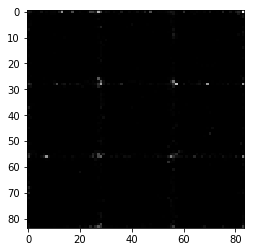

Epoch 1/2... Discriminator Loss: 0.6877... Generator Loss: 1.6256
Epoch 1/2... Discriminator Loss: 0.7318... Generator Loss: 1.4546
Epoch 1/2... Discriminator Loss: 0.8156... Generator Loss: 1.4829
Epoch 1/2... Discriminator Loss: 0.5786... Generator Loss: 2.5594
Epoch 1/2... Discriminator Loss: 1.3011... Generator Loss: 0.6863
Epoch 1/2... Discriminator Loss: 0.7465... Generator Loss: 2.1527
Epoch 1/2... Discriminator Loss: 0.8731... Generator Loss: 1.3393
Epoch 1/2... Discriminator Loss: 0.6899... Generator Loss: 1.5808
Epoch 1/2... Discriminator Loss: 0.6821... Generator Loss: 2.0424
Epoch 1/2... Discriminator Loss: 0.8773... Generator Loss: 1.4114


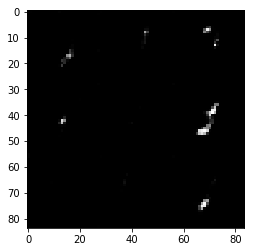

Epoch 1/2... Discriminator Loss: 0.8722... Generator Loss: 1.6294
Epoch 1/2... Discriminator Loss: 0.9338... Generator Loss: 1.2951
Epoch 1/2... Discriminator Loss: 1.6685... Generator Loss: 0.7860
Epoch 1/2... Discriminator Loss: 1.0200... Generator Loss: 1.9242
Epoch 1/2... Discriminator Loss: 1.1358... Generator Loss: 1.7996
Epoch 1/2... Discriminator Loss: 0.7431... Generator Loss: 1.5141
Epoch 1/2... Discriminator Loss: 0.6353... Generator Loss: 1.9602
Epoch 1/2... Discriminator Loss: 0.8071... Generator Loss: 1.7625
Epoch 1/2... Discriminator Loss: 1.1130... Generator Loss: 0.9873
Epoch 1/2... Discriminator Loss: 0.6380... Generator Loss: 2.0157


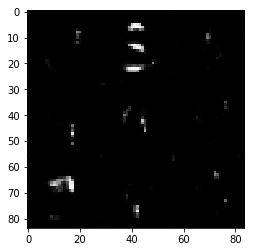

Epoch 1/2... Discriminator Loss: 1.4361... Generator Loss: 0.8691
Epoch 1/2... Discriminator Loss: 0.7695... Generator Loss: 1.6679
Epoch 1/2... Discriminator Loss: 0.9846... Generator Loss: 0.9997
Epoch 1/2... Discriminator Loss: 0.7817... Generator Loss: 1.6578
Epoch 1/2... Discriminator Loss: 0.7125... Generator Loss: 1.5786
Epoch 1/2... Discriminator Loss: 0.9200... Generator Loss: 1.4159
Epoch 1/2... Discriminator Loss: 0.7388... Generator Loss: 1.7818
Epoch 1/2... Discriminator Loss: 0.8545... Generator Loss: 1.7014
Epoch 1/2... Discriminator Loss: 0.7324... Generator Loss: 1.6468
Epoch 1/2... Discriminator Loss: 1.2117... Generator Loss: 0.8329


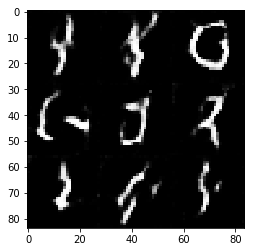

Epoch 1/2... Discriminator Loss: 0.7580... Generator Loss: 1.6541
Epoch 1/2... Discriminator Loss: 0.9533... Generator Loss: 1.1954
Epoch 1/2... Discriminator Loss: 0.8105... Generator Loss: 1.3478
Epoch 1/2... Discriminator Loss: 0.8943... Generator Loss: 1.2908
Epoch 1/2... Discriminator Loss: 0.7285... Generator Loss: 1.5307
Epoch 1/2... Discriminator Loss: 0.6198... Generator Loss: 2.1917
Epoch 1/2... Discriminator Loss: 1.6218... Generator Loss: 0.6287
Epoch 1/2... Discriminator Loss: 0.9468... Generator Loss: 2.8142
Epoch 1/2... Discriminator Loss: 0.9565... Generator Loss: 1.2604
Epoch 1/2... Discriminator Loss: 1.0944... Generator Loss: 1.1110


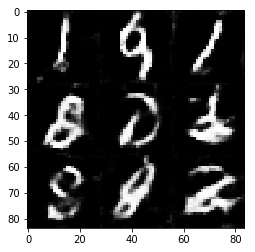

Epoch 1/2... Discriminator Loss: 0.8462... Generator Loss: 1.5413
Epoch 1/2... Discriminator Loss: 0.7851... Generator Loss: 1.7947
Epoch 1/2... Discriminator Loss: 0.7379... Generator Loss: 1.9787
Epoch 1/2... Discriminator Loss: 0.7787... Generator Loss: 1.6566
Epoch 1/2... Discriminator Loss: 0.7640... Generator Loss: 1.4737
Epoch 1/2... Discriminator Loss: 0.9075... Generator Loss: 1.2094
Epoch 1/2... Discriminator Loss: 0.8177... Generator Loss: 2.7444
Epoch 1/2... Discriminator Loss: 0.8216... Generator Loss: 2.0724
Epoch 1/2... Discriminator Loss: 0.9584... Generator Loss: 1.0957
Epoch 1/2... Discriminator Loss: 0.6569... Generator Loss: 2.4098


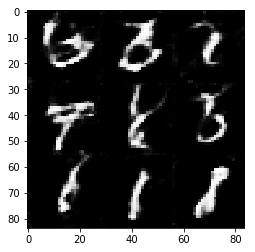

Epoch 1/2... Discriminator Loss: 0.5579... Generator Loss: 2.0940
Epoch 1/2... Discriminator Loss: 0.8523... Generator Loss: 1.3172
Epoch 1/2... Discriminator Loss: 0.6416... Generator Loss: 2.1677
Epoch 1/2... Discriminator Loss: 1.0643... Generator Loss: 0.9469
Epoch 1/2... Discriminator Loss: 0.8415... Generator Loss: 1.2991
Epoch 1/2... Discriminator Loss: 0.7927... Generator Loss: 2.0642
Epoch 1/2... Discriminator Loss: 0.8970... Generator Loss: 1.3472
Epoch 1/2... Discriminator Loss: 0.8495... Generator Loss: 1.4997
Epoch 1/2... Discriminator Loss: 1.0169... Generator Loss: 1.0383
Epoch 1/2... Discriminator Loss: 0.6873... Generator Loss: 1.6989


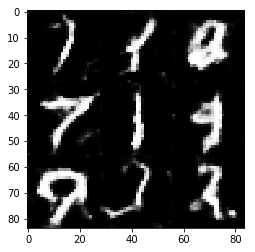

Epoch 1/2... Discriminator Loss: 0.7221... Generator Loss: 1.8740
Epoch 1/2... Discriminator Loss: 0.7648... Generator Loss: 1.8434
Epoch 1/2... Discriminator Loss: 0.7437... Generator Loss: 1.6702
Epoch 1/2... Discriminator Loss: 0.6279... Generator Loss: 1.9143
Epoch 1/2... Discriminator Loss: 0.6135... Generator Loss: 2.0902
Epoch 1/2... Discriminator Loss: 0.7095... Generator Loss: 2.0046
Epoch 1/2... Discriminator Loss: 0.5893... Generator Loss: 2.6610
Epoch 1/2... Discriminator Loss: 0.6642... Generator Loss: 1.7596
Epoch 1/2... Discriminator Loss: 0.7730... Generator Loss: 2.2053
Epoch 1/2... Discriminator Loss: 0.6714... Generator Loss: 2.9096


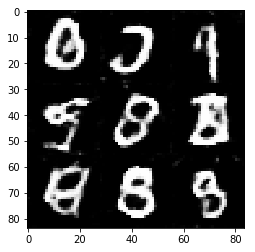

Epoch 1/2... Discriminator Loss: 0.6994... Generator Loss: 2.2886
Epoch 1/2... Discriminator Loss: 0.6995... Generator Loss: 1.9820
Epoch 1/2... Discriminator Loss: 0.7189... Generator Loss: 2.0525
Epoch 1/2... Discriminator Loss: 0.9145... Generator Loss: 1.5754
Epoch 1/2... Discriminator Loss: 0.6598... Generator Loss: 2.0324
Epoch 1/2... Discriminator Loss: 0.6219... Generator Loss: 2.1265
Epoch 1/2... Discriminator Loss: 1.0662... Generator Loss: 3.4777
Epoch 1/2... Discriminator Loss: 1.8525... Generator Loss: 0.4686
Epoch 1/2... Discriminator Loss: 0.8295... Generator Loss: 1.4867
Epoch 1/2... Discriminator Loss: 0.6678... Generator Loss: 2.0203


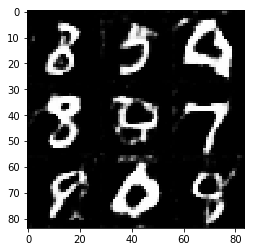

Epoch 1/2... Discriminator Loss: 0.7579... Generator Loss: 1.6185
Epoch 1/2... Discriminator Loss: 0.5967... Generator Loss: 2.1182
Epoch 1/2... Discriminator Loss: 0.6892... Generator Loss: 2.1863
Epoch 1/2... Discriminator Loss: 0.8288... Generator Loss: 1.4709
Epoch 2/2... Discriminator Loss: 0.5671... Generator Loss: 2.1794
Epoch 2/2... Discriminator Loss: 0.6893... Generator Loss: 1.6083
Epoch 2/2... Discriminator Loss: 0.6153... Generator Loss: 1.9746
Epoch 2/2... Discriminator Loss: 0.7228... Generator Loss: 2.4311
Epoch 2/2... Discriminator Loss: 0.6866... Generator Loss: 2.2797
Epoch 2/2... Discriminator Loss: 0.7414... Generator Loss: 2.4210


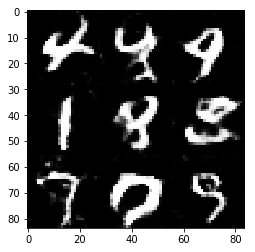

Epoch 2/2... Discriminator Loss: 0.6775... Generator Loss: 1.7904
Epoch 2/2... Discriminator Loss: 0.6210... Generator Loss: 2.4551
Epoch 2/2... Discriminator Loss: 0.5764... Generator Loss: 2.3124
Epoch 2/2... Discriminator Loss: 0.4837... Generator Loss: 2.7902
Epoch 2/2... Discriminator Loss: 0.8964... Generator Loss: 3.5645
Epoch 2/2... Discriminator Loss: 0.6744... Generator Loss: 2.1561
Epoch 2/2... Discriminator Loss: 0.7745... Generator Loss: 1.7500
Epoch 2/2... Discriminator Loss: 0.5941... Generator Loss: 2.3697
Epoch 2/2... Discriminator Loss: 0.6212... Generator Loss: 2.3842
Epoch 2/2... Discriminator Loss: 1.0738... Generator Loss: 1.0027


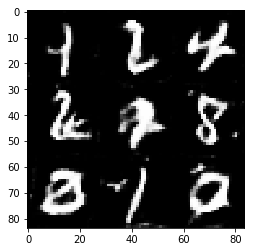

Epoch 2/2... Discriminator Loss: 0.7579... Generator Loss: 1.9157
Epoch 2/2... Discriminator Loss: 0.5657... Generator Loss: 2.7939
Epoch 2/2... Discriminator Loss: 0.6533... Generator Loss: 2.4365
Epoch 2/2... Discriminator Loss: 0.5831... Generator Loss: 1.7377
Epoch 2/2... Discriminator Loss: 0.5755... Generator Loss: 2.6247
Epoch 2/2... Discriminator Loss: 0.7553... Generator Loss: 1.9106
Epoch 2/2... Discriminator Loss: 0.5605... Generator Loss: 2.5178
Epoch 2/2... Discriminator Loss: 0.5186... Generator Loss: 2.6512
Epoch 2/2... Discriminator Loss: 0.8626... Generator Loss: 2.7946
Epoch 2/2... Discriminator Loss: 0.6469... Generator Loss: 2.1047


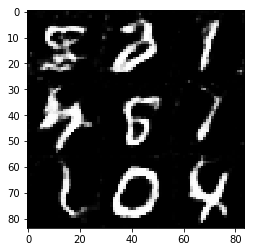

Epoch 2/2... Discriminator Loss: 0.5564... Generator Loss: 2.3102
Epoch 2/2... Discriminator Loss: 0.6945... Generator Loss: 2.1142
Epoch 2/2... Discriminator Loss: 0.6322... Generator Loss: 2.7794
Epoch 2/2... Discriminator Loss: 0.6134... Generator Loss: 2.9666
Epoch 2/2... Discriminator Loss: 0.7029... Generator Loss: 3.1713
Epoch 2/2... Discriminator Loss: 0.7658... Generator Loss: 1.5929
Epoch 2/2... Discriminator Loss: 0.9325... Generator Loss: 1.6290
Epoch 2/2... Discriminator Loss: 0.6191... Generator Loss: 2.7775
Epoch 2/2... Discriminator Loss: 0.7955... Generator Loss: 1.7972
Epoch 2/2... Discriminator Loss: 0.4987... Generator Loss: 2.6842


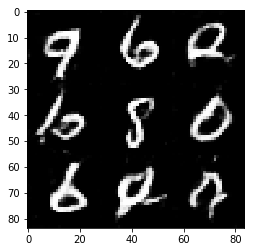

Epoch 2/2... Discriminator Loss: 0.7701... Generator Loss: 1.5089
Epoch 2/2... Discriminator Loss: 0.5692... Generator Loss: 2.6105
Epoch 2/2... Discriminator Loss: 0.8523... Generator Loss: 1.6472
Epoch 2/2... Discriminator Loss: 0.6424... Generator Loss: 2.0446
Epoch 2/2... Discriminator Loss: 0.6756... Generator Loss: 2.3891
Epoch 2/2... Discriminator Loss: 0.6690... Generator Loss: 2.1781
Epoch 2/2... Discriminator Loss: 1.1927... Generator Loss: 1.2506
Epoch 2/2... Discriminator Loss: 0.6722... Generator Loss: 2.2575
Epoch 2/2... Discriminator Loss: 0.5366... Generator Loss: 2.7995
Epoch 2/2... Discriminator Loss: 0.5940... Generator Loss: 2.0689


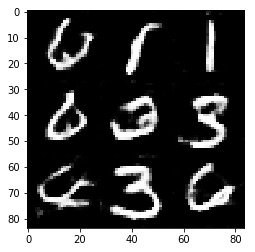

Epoch 2/2... Discriminator Loss: 0.5223... Generator Loss: 2.8305
Epoch 2/2... Discriminator Loss: 0.6894... Generator Loss: 3.3956
Epoch 2/2... Discriminator Loss: 0.7490... Generator Loss: 2.2106
Epoch 2/2... Discriminator Loss: 0.7645... Generator Loss: 1.8817
Epoch 2/2... Discriminator Loss: 0.6166... Generator Loss: 1.5642
Epoch 2/2... Discriminator Loss: 0.5893... Generator Loss: 1.7609
Epoch 2/2... Discriminator Loss: 0.6234... Generator Loss: 1.5444
Epoch 2/2... Discriminator Loss: 0.6381... Generator Loss: 1.8418
Epoch 2/2... Discriminator Loss: 0.7028... Generator Loss: 2.4395
Epoch 2/2... Discriminator Loss: 0.5049... Generator Loss: 3.1210


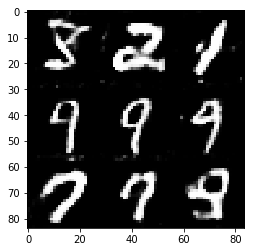

Epoch 2/2... Discriminator Loss: 0.5797... Generator Loss: 2.1958
Epoch 2/2... Discriminator Loss: 0.6447... Generator Loss: 2.5848
Epoch 2/2... Discriminator Loss: 0.6556... Generator Loss: 2.5855
Epoch 2/2... Discriminator Loss: 0.6417... Generator Loss: 2.1967
Epoch 2/2... Discriminator Loss: 0.5246... Generator Loss: 2.6907
Epoch 2/2... Discriminator Loss: 0.6230... Generator Loss: 2.3042
Epoch 2/2... Discriminator Loss: 0.5805... Generator Loss: 1.8083
Epoch 2/2... Discriminator Loss: 0.6859... Generator Loss: 1.8575
Epoch 2/2... Discriminator Loss: 0.5636... Generator Loss: 2.8724
Epoch 2/2... Discriminator Loss: 0.5378... Generator Loss: 2.6545


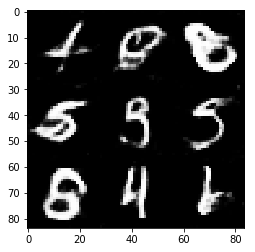

Epoch 2/2... Discriminator Loss: 0.6495... Generator Loss: 2.0801
Epoch 2/2... Discriminator Loss: 0.6717... Generator Loss: 2.2189
Epoch 2/2... Discriminator Loss: 0.5589... Generator Loss: 3.3073
Epoch 2/2... Discriminator Loss: 0.6040... Generator Loss: 2.3501
Epoch 2/2... Discriminator Loss: 1.1077... Generator Loss: 1.8064
Epoch 2/2... Discriminator Loss: 0.5841... Generator Loss: 2.5939
Epoch 2/2... Discriminator Loss: 0.6205... Generator Loss: 1.8883
Epoch 2/2... Discriminator Loss: 0.6001... Generator Loss: 2.8633
Epoch 2/2... Discriminator Loss: 0.6020... Generator Loss: 2.8814
Epoch 2/2... Discriminator Loss: 0.6163... Generator Loss: 2.6009


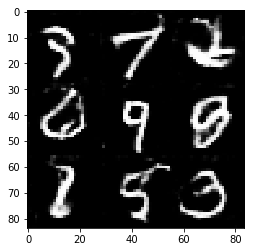

Epoch 2/2... Discriminator Loss: 0.7398... Generator Loss: 4.6172
Epoch 2/2... Discriminator Loss: 0.8629... Generator Loss: 1.5902
Epoch 2/2... Discriminator Loss: 0.6591... Generator Loss: 1.7807
Epoch 2/2... Discriminator Loss: 0.7627... Generator Loss: 1.7329
Epoch 2/2... Discriminator Loss: 0.5146... Generator Loss: 2.4419
Epoch 2/2... Discriminator Loss: 0.7905... Generator Loss: 1.5100
Epoch 2/2... Discriminator Loss: 0.5408... Generator Loss: 2.7443
Epoch 2/2... Discriminator Loss: 0.5218... Generator Loss: 2.4538
Epoch 2/2... Discriminator Loss: 0.6930... Generator Loss: 2.2223
Epoch 2/2... Discriminator Loss: 0.4425... Generator Loss: 3.1900


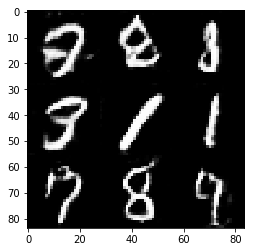

Epoch 2/2... Discriminator Loss: 0.9510... Generator Loss: 1.6547
Epoch 2/2... Discriminator Loss: 0.7013... Generator Loss: 2.0542
Epoch 2/2... Discriminator Loss: 0.6773... Generator Loss: 2.1630
Epoch 2/2... Discriminator Loss: 0.8451... Generator Loss: 1.8475
Epoch 2/2... Discriminator Loss: 0.8034... Generator Loss: 2.1277
Epoch 2/2... Discriminator Loss: 0.8660... Generator Loss: 1.4120
Epoch 2/2... Discriminator Loss: 0.5037... Generator Loss: 2.4975
Epoch 2/2... Discriminator Loss: 0.7636... Generator Loss: 2.3228


In [29]:
batch_size = 64
z_dim = 100
learning_rate = 0.001
beta1 = 0.5

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Discriminator Loss: 1.4433... Generator Loss: 1.0868
Epoch 1/1... Discriminator Loss: 0.5508... Generator Loss: 2.9117
Epoch 1/1... Discriminator Loss: 0.7619... Generator Loss: 2.2728
Epoch 1/1... Discriminator Loss: 0.8519... Generator Loss: 1.4739
Epoch 1/1... Discriminator Loss: 0.5581... Generator Loss: 2.4464
Epoch 1/1... Discriminator Loss: 0.4411... Generator Loss: 3.6109
Epoch 1/1... Discriminator Loss: 0.3834... Generator Loss: 4.2254
Epoch 1/1... Discriminator Loss: 0.8329... Generator Loss: 2.2435
Epoch 1/1... Discriminator Loss: 1.1450... Generator Loss: 1.3653


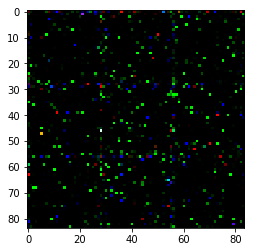

Epoch 1/1... Discriminator Loss: 1.0141... Generator Loss: 1.0412
Epoch 1/1... Discriminator Loss: 0.6206... Generator Loss: 1.8495
Epoch 1/1... Discriminator Loss: 0.9111... Generator Loss: 1.1710
Epoch 1/1... Discriminator Loss: 0.4286... Generator Loss: 2.8346
Epoch 1/1... Discriminator Loss: 0.9726... Generator Loss: 1.3628
Epoch 1/1... Discriminator Loss: 0.8276... Generator Loss: 2.0900
Epoch 1/1... Discriminator Loss: 0.6442... Generator Loss: 1.7165
Epoch 1/1... Discriminator Loss: 1.8742... Generator Loss: 0.4449
Epoch 1/1... Discriminator Loss: 1.0634... Generator Loss: 0.9502
Epoch 1/1... Discriminator Loss: 0.7495... Generator Loss: 1.5739


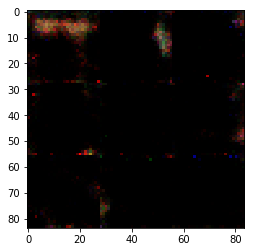

Epoch 1/1... Discriminator Loss: 1.3980... Generator Loss: 0.6345
Epoch 1/1... Discriminator Loss: 0.6858... Generator Loss: 1.6955
Epoch 1/1... Discriminator Loss: 1.4230... Generator Loss: 0.7995
Epoch 1/1... Discriminator Loss: 0.8094... Generator Loss: 1.4687
Epoch 1/1... Discriminator Loss: 0.8809... Generator Loss: 1.0706
Epoch 1/1... Discriminator Loss: 0.9956... Generator Loss: 1.0479
Epoch 1/1... Discriminator Loss: 0.7212... Generator Loss: 1.4735
Epoch 1/1... Discriminator Loss: 0.7588... Generator Loss: 1.6853
Epoch 1/1... Discriminator Loss: 1.3384... Generator Loss: 0.7335
Epoch 1/1... Discriminator Loss: 0.6390... Generator Loss: 1.7892


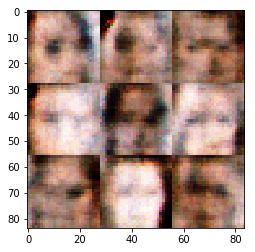

Epoch 1/1... Discriminator Loss: 1.1919... Generator Loss: 0.9851
Epoch 1/1... Discriminator Loss: 1.2552... Generator Loss: 0.8631
Epoch 1/1... Discriminator Loss: 0.6926... Generator Loss: 1.6750
Epoch 1/1... Discriminator Loss: 0.8275... Generator Loss: 2.0702
Epoch 1/1... Discriminator Loss: 0.7053... Generator Loss: 2.1077
Epoch 1/1... Discriminator Loss: 0.8359... Generator Loss: 1.3636
Epoch 1/1... Discriminator Loss: 0.6128... Generator Loss: 2.1617
Epoch 1/1... Discriminator Loss: 0.8146... Generator Loss: 1.6478
Epoch 1/1... Discriminator Loss: 0.6278... Generator Loss: 1.7572
Epoch 1/1... Discriminator Loss: 0.6477... Generator Loss: 2.0481


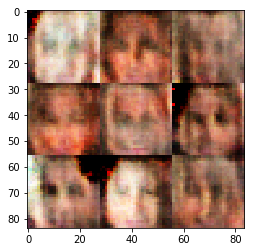

Epoch 1/1... Discriminator Loss: 1.1262... Generator Loss: 1.0986
Epoch 1/1... Discriminator Loss: 0.6871... Generator Loss: 1.6484
Epoch 1/1... Discriminator Loss: 0.8079... Generator Loss: 1.3461
Epoch 1/1... Discriminator Loss: 0.9826... Generator Loss: 1.2414
Epoch 1/1... Discriminator Loss: 0.8742... Generator Loss: 1.2080
Epoch 1/1... Discriminator Loss: 0.9873... Generator Loss: 1.6314
Epoch 1/1... Discriminator Loss: 0.7855... Generator Loss: 1.5048
Epoch 1/1... Discriminator Loss: 0.7167... Generator Loss: 1.6116
Epoch 1/1... Discriminator Loss: 1.3540... Generator Loss: 0.6777
Epoch 1/1... Discriminator Loss: 1.3873... Generator Loss: 0.6781


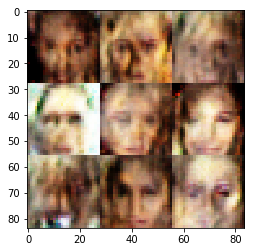

Epoch 1/1... Discriminator Loss: 0.7635... Generator Loss: 1.6015
Epoch 1/1... Discriminator Loss: 0.7126... Generator Loss: 1.8129
Epoch 1/1... Discriminator Loss: 0.7022... Generator Loss: 1.7543
Epoch 1/1... Discriminator Loss: 0.9483... Generator Loss: 1.2410
Epoch 1/1... Discriminator Loss: 0.7863... Generator Loss: 1.6929
Epoch 1/1... Discriminator Loss: 0.7912... Generator Loss: 1.6181
Epoch 1/1... Discriminator Loss: 0.7939... Generator Loss: 1.6499
Epoch 1/1... Discriminator Loss: 1.7763... Generator Loss: 0.3720
Epoch 1/1... Discriminator Loss: 0.8248... Generator Loss: 1.4314
Epoch 1/1... Discriminator Loss: 0.9269... Generator Loss: 1.4031


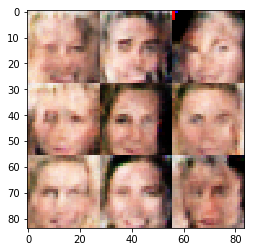

Epoch 1/1... Discriminator Loss: 1.7253... Generator Loss: 0.7974
Epoch 1/1... Discriminator Loss: 0.8072... Generator Loss: 1.4607
Epoch 1/1... Discriminator Loss: 1.2568... Generator Loss: 0.7222
Epoch 1/1... Discriminator Loss: 0.9502... Generator Loss: 1.0814
Epoch 1/1... Discriminator Loss: 0.9647... Generator Loss: 1.2009
Epoch 1/1... Discriminator Loss: 0.9944... Generator Loss: 1.3257
Epoch 1/1... Discriminator Loss: 0.9039... Generator Loss: 1.2433
Epoch 1/1... Discriminator Loss: 0.8200... Generator Loss: 1.6479
Epoch 1/1... Discriminator Loss: 1.0073... Generator Loss: 0.7697
Epoch 1/1... Discriminator Loss: 1.3906... Generator Loss: 0.6622


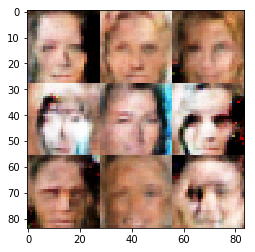

Epoch 1/1... Discriminator Loss: 1.5410... Generator Loss: 0.7213
Epoch 1/1... Discriminator Loss: 0.8749... Generator Loss: 1.3217
Epoch 1/1... Discriminator Loss: 0.9671... Generator Loss: 1.6897
Epoch 1/1... Discriminator Loss: 0.9202... Generator Loss: 0.9661
Epoch 1/1... Discriminator Loss: 0.9052... Generator Loss: 1.1500
Epoch 1/1... Discriminator Loss: 0.9964... Generator Loss: 1.3076
Epoch 1/1... Discriminator Loss: 0.8035... Generator Loss: 1.4344
Epoch 1/1... Discriminator Loss: 1.1883... Generator Loss: 0.9296
Epoch 1/1... Discriminator Loss: 1.0382... Generator Loss: 1.3187
Epoch 1/1... Discriminator Loss: 0.8302... Generator Loss: 1.3026


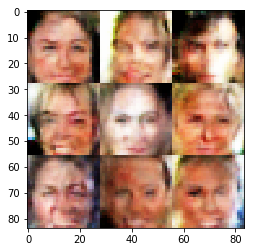

Epoch 1/1... Discriminator Loss: 0.8730... Generator Loss: 1.4651
Epoch 1/1... Discriminator Loss: 0.8953... Generator Loss: 1.4806
Epoch 1/1... Discriminator Loss: 1.5544... Generator Loss: 0.6406
Epoch 1/1... Discriminator Loss: 1.2298... Generator Loss: 0.7715
Epoch 1/1... Discriminator Loss: 0.9676... Generator Loss: 1.6801
Epoch 1/1... Discriminator Loss: 1.1037... Generator Loss: 1.2661
Epoch 1/1... Discriminator Loss: 1.0216... Generator Loss: 1.0985
Epoch 1/1... Discriminator Loss: 1.0610... Generator Loss: 0.9155
Epoch 1/1... Discriminator Loss: 0.9574... Generator Loss: 1.2434
Epoch 1/1... Discriminator Loss: 0.9228... Generator Loss: 1.6377


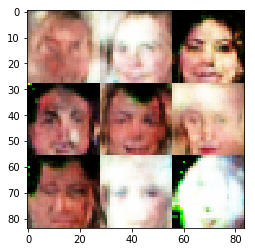

Epoch 1/1... Discriminator Loss: 0.8403... Generator Loss: 1.6590
Epoch 1/1... Discriminator Loss: 1.0241... Generator Loss: 0.9687
Epoch 1/1... Discriminator Loss: 0.7758... Generator Loss: 1.3321
Epoch 1/1... Discriminator Loss: 0.8071... Generator Loss: 1.5078
Epoch 1/1... Discriminator Loss: 0.8241... Generator Loss: 1.1829
Epoch 1/1... Discriminator Loss: 0.8366... Generator Loss: 1.4342
Epoch 1/1... Discriminator Loss: 0.9637... Generator Loss: 0.9457
Epoch 1/1... Discriminator Loss: 0.8383... Generator Loss: 1.3236
Epoch 1/1... Discriminator Loss: 0.9127... Generator Loss: 1.1349
Epoch 1/1... Discriminator Loss: 1.0053... Generator Loss: 1.1052


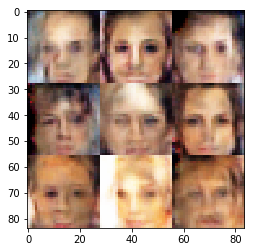

Epoch 1/1... Discriminator Loss: 0.9134... Generator Loss: 1.4478
Epoch 1/1... Discriminator Loss: 0.7896... Generator Loss: 1.2942
Epoch 1/1... Discriminator Loss: 0.9592... Generator Loss: 1.2008
Epoch 1/1... Discriminator Loss: 1.3166... Generator Loss: 0.6126
Epoch 1/1... Discriminator Loss: 0.8305... Generator Loss: 1.0980
Epoch 1/1... Discriminator Loss: 0.7678... Generator Loss: 1.5370
Epoch 1/1... Discriminator Loss: 0.7398... Generator Loss: 1.4899
Epoch 1/1... Discriminator Loss: 0.9189... Generator Loss: 1.1808
Epoch 1/1... Discriminator Loss: 0.9355... Generator Loss: 1.7923
Epoch 1/1... Discriminator Loss: 0.8815... Generator Loss: 1.6535


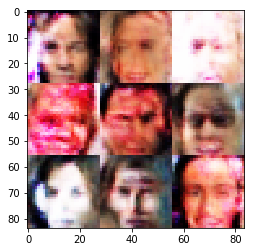

Epoch 1/1... Discriminator Loss: 0.8912... Generator Loss: 1.5031
Epoch 1/1... Discriminator Loss: 0.8564... Generator Loss: 1.3065
Epoch 1/1... Discriminator Loss: 0.9198... Generator Loss: 1.3611
Epoch 1/1... Discriminator Loss: 0.9564... Generator Loss: 1.4022
Epoch 1/1... Discriminator Loss: 0.8569... Generator Loss: 1.4815
Epoch 1/1... Discriminator Loss: 0.8782... Generator Loss: 1.4590
Epoch 1/1... Discriminator Loss: 1.0496... Generator Loss: 1.2651
Epoch 1/1... Discriminator Loss: 1.0109... Generator Loss: 1.2429
Epoch 1/1... Discriminator Loss: 0.8930... Generator Loss: 1.5038
Epoch 1/1... Discriminator Loss: 1.1489... Generator Loss: 0.9965


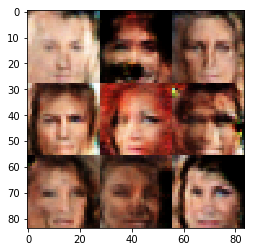

Epoch 1/1... Discriminator Loss: 0.9009... Generator Loss: 1.4256
Epoch 1/1... Discriminator Loss: 0.8189... Generator Loss: 1.5477


KeyboardInterrupt: 

In [30]:
batch_size = 64
z_dim = 100
learning_rate = 0.001
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.